## Libraries and Data

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_info = pd.read_csv('/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv')
data_info.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [3]:
PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

data = {'images':[], 'mask':[]}
    
data['mask'] = glob.glob(PATH + '*/*_mask*')
for i in data['mask']:
    data['images'].append(i.replace('_mask',''))

df = pd.DataFrame(data)
df.head()

,images,mask
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [4]:
##Test
idx = np.random.randint(len(df))
print(data['mask'][idx])
print(data['images'][idx])

/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_18_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_18.tif


In [5]:
def tumour_detection(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 :
        return 1
    else:
        return 0

df['tumour'] = df["mask"].apply(lambda x: tumour_detection(x))
df

,images,mask,tumour
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
...,...,...,...
3924,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [6]:
df['tumour'].value_counts()

tumour
0    2556
1    1373
Name: count, dtype: int64

## Data Visualization

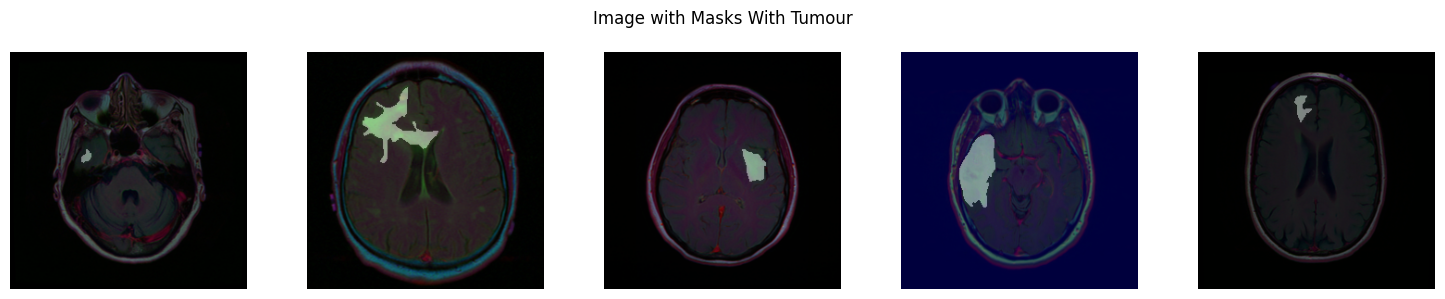

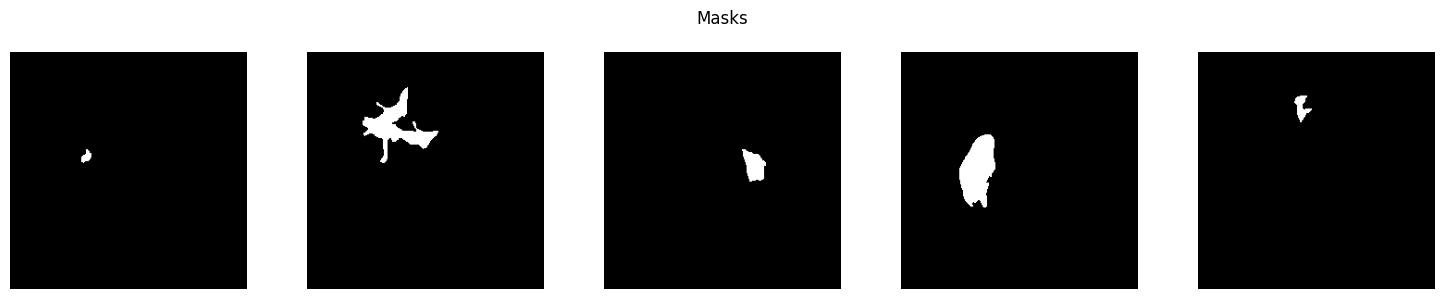

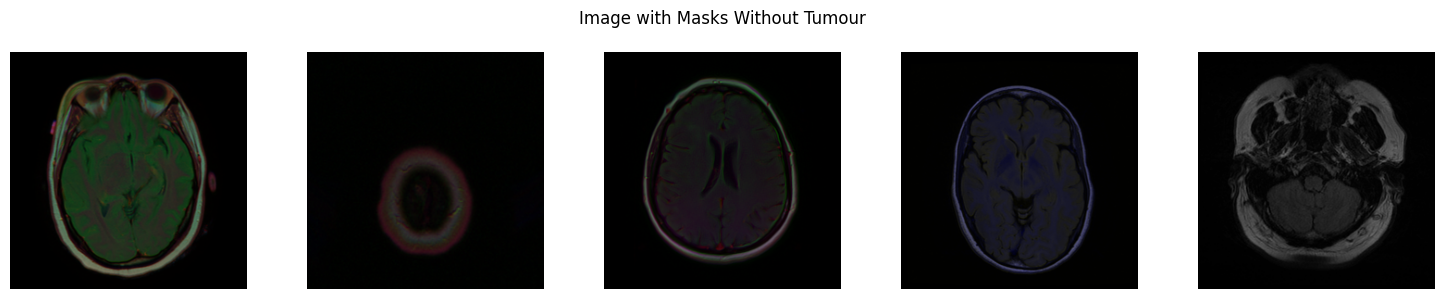

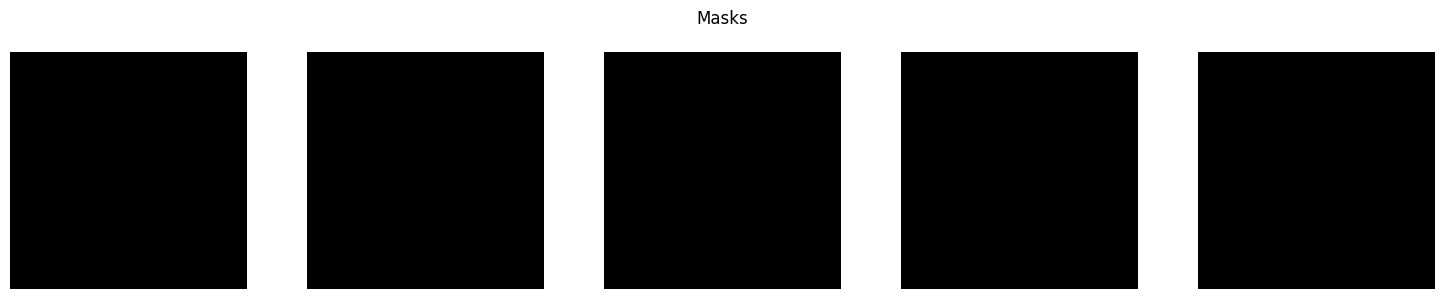

In [7]:
img = df[df['tumour']==1].sample(5)
img = img.reset_index()

plt.figure(figsize=(15,3))
plt.suptitle('Image with Masks With Tumour')
for i in range(len(img)):
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.imread(img['images'][i]))
    plt.imshow(cv2.imread(img['mask'][i]), alpha = 0.4)
    plt.axis('off')
plt.tight_layout()
plt.show()
    
plt.figure(figsize=(15,3))
plt.suptitle('Masks')
for i in range(len(img)):
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.imread(img['mask'][i]))
    plt.axis('off')
    
plt.tight_layout()
plt.show()



img = df[df['tumour']==0].sample(5)
img = img.reset_index()

plt.figure(figsize=(15,3))
plt.suptitle('Image with Masks Without Tumour')
for i in range(len(img)):
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.imread(img['images'][i]))
    plt.imshow(cv2.imread(img['mask'][i]), alpha = 0.4)
    plt.axis('off')
plt.tight_layout()
plt.show()
    
plt.figure(figsize=(15,3))
plt.suptitle('Masks')
for i in range(len(img)):
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.imread(img['mask'][i]))
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## Spliting Data

In [8]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=101, stratify=df.tumour, shuffle=True)
test_data, valid_data = train_test_split(test_data, test_size=0.5, random_state=101, stratify=test_data.tumour, shuffle=True)

print(f'train data: {len(train_data)}')
print(f'valid_data: {len(valid_data)}')
print(f'test_data : {len(test_data)}')

train data: 3143
valid_data: 393
test_data : 393


## Data Augmentation

In [9]:
df['tumour'] = df['tumour'].apply(lambda x: str(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  3929 non-null   object
 1   mask    3929 non-null   object
 2   tumour  3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [10]:
def train_generator(data_frame, batch_size, target_size=(128,128), train = True, seed=1):
    
    if train:
        
        image_datagen = ImageDataGenerator(rotation_range=0.2, width_shift_range=0.05, height_shift_range=0.05, shear_range=0.05,
                                            zoom_range=0.05, horizontal_flip=True, fill_mode='nearest')

        mask_datagen = ImageDataGenerator(rotation_range=0.2, width_shift_range=0.05, height_shift_range=0.05, shear_range=0.05,
                                          zoom_range=0.05, horizontal_flip=True, fill_mode='nearest')
        
    else:
        image_datagen = ImageDataGenerator()

        mask_datagen = ImageDataGenerator()
                                       
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "images",
        color_mode = 'rgb',
        class_mode = None,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        color_mode = 'grayscale',
        class_mode = None,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)
                                       
                                                                  
    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img = img/255.
        mask = mask/255.
        mask[mask >= 0.5] = 1
        mask[mask < 0.5] = 0
                                       
        yield (img, mask)

In [13]:
BATCH_SIZE = 40
im_height = 128
im_width = 128

train_gen = train_generator(train_data, BATCH_SIZE, target_size=(im_height,im_width), train = True, seed=1)
valid_gen = train_generator(valid_data, BATCH_SIZE, target_size=(im_height,im_width), train = False, seed=1)
test_gen = train_generator(test_data, BATCH_SIZE, target_size=(im_height,im_width), train = False, seed=1)

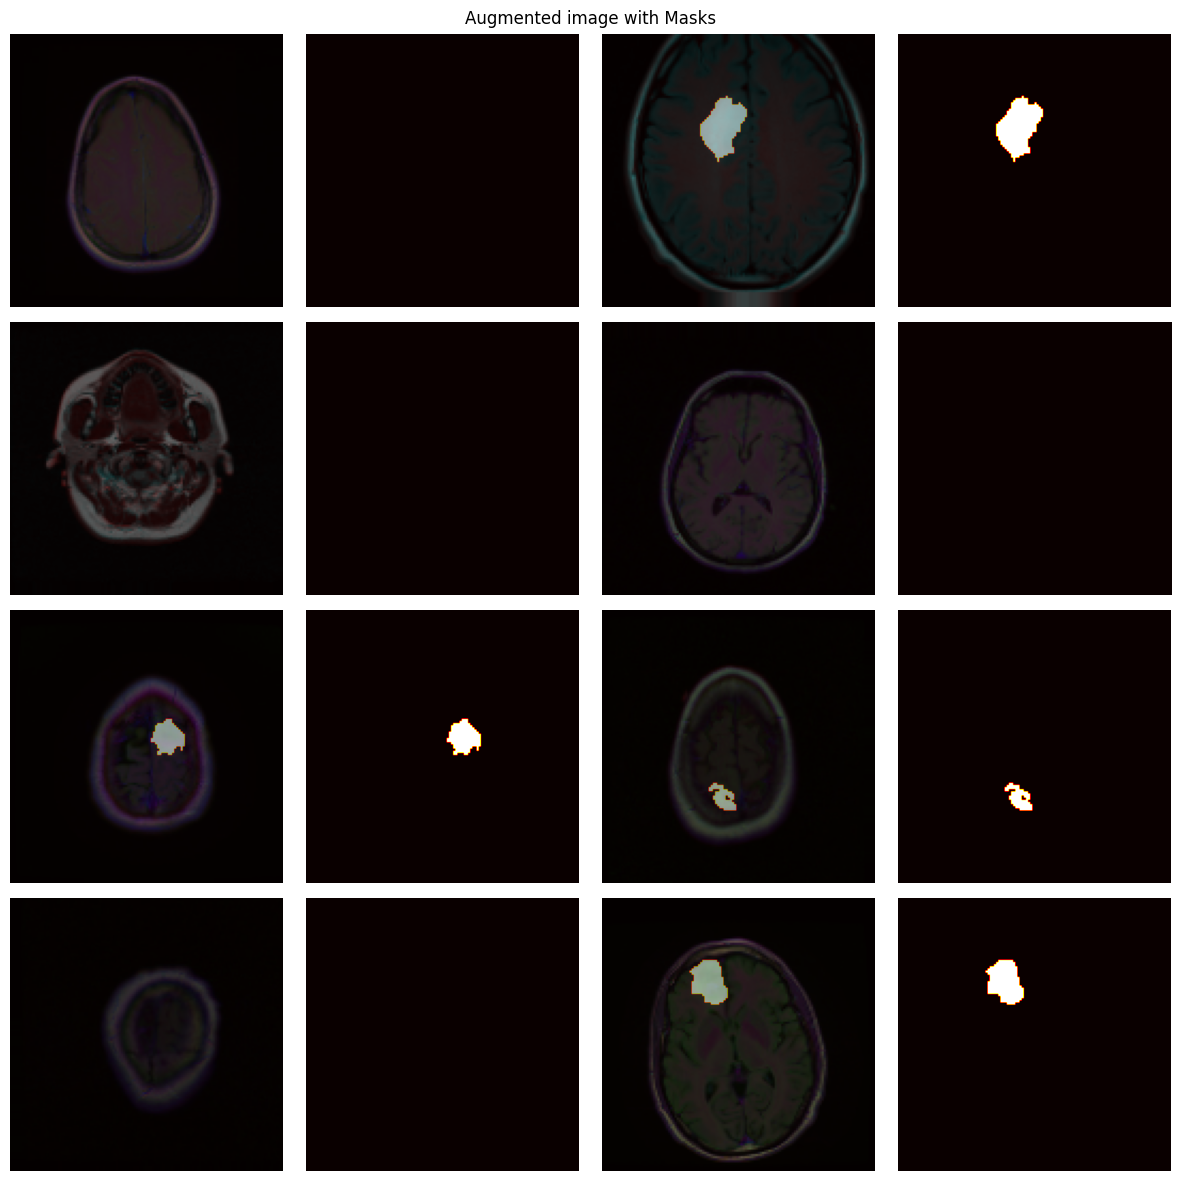

In [38]:
for (img, mask) in train_gen:
    break

idx = [0, 2, 4, 6, 8, 10, 12, 14]

plt.figure(figsize=(12, 12))
plt.suptitle('Augmented image with Masks')
for i in idx:
    plt.subplot(4, 4, i+1)
    image = (img[i]*255).astype(np.uint8)
    plt.imshow(image, cmap = 'gray')
    plt.imshow(mask[i], alpha = 0.5, cmap = 'hot')
    plt.axis('off')
    plt.subplot(4, 4, i+2)
    plt.imshow(mask[i], cmap = 'hot')
    plt.axis('off')

plt.tight_layout()
plt.show()

# 

## Define Loss and metrics

In [16]:
def dice_coef(y_true, y_pred, smooth=100):

    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) +  K.sum(y_pred)
    return (2 * intersection)/(union + smooth)

def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) +  K.sum(y_pred)
    iou = (intersection)/(union - intersection + smooth)
    return iou

## Deifine model 

In [17]:
def conv_down(inputs, num_filter):
    
    conv1 = Conv2D(num_filter, (3, 3), padding='same')(inputs)
    act1 = Activation('relu')(conv1)
    conv2 = Conv2D(num_filter, (3, 3), padding='same')(act1)
    bn = BatchNormalization(axis=3)(conv2)                            
    act2 = Activation('relu')(bn)
    drp = Dropout(0.1)(act2)
    pool = MaxPooling2D(pool_size=(2, 2))(drp)
    
    return conv2, pool, drp

def conv_up(input1, input2, num_filter1, num_filter2):
    
    up1 = Conv2DTranspose(num_filter1, (2, 2), strides=(2, 2), padding='same')(input1)
    up2 = concatenate([up1, input2], axis=3)
    conv1 = Conv2D(num_filter2, (3, 3), padding='same')(up2)
    act1 = Activation('relu')(conv1)
    conv2 = Conv2D(num_filter2, (3, 3), padding='same')(act1)
    bn1 = BatchNormalization(axis=3)(conv2)                            
    act2 = Activation('relu')(bn1)
    drp = Dropout(0.1)(act2)
    return drp

In [18]:
def unet(input_size=(128,128,3)):
    
    inputs = Input(input_size)
    
    conv1, pool1, _ = conv_down(inputs, 32)
    conv2, pool2, _ = conv_down(pool1, 64)    
    conv3, pool3, _ = conv_down(pool2, 128)    
    conv4, pool4, _ = conv_down(pool3, 256)    
    _, _ , drp = conv_down(pool4, 512)   
    
    drp1 = conv_up(drp, conv4, 512, 256)
    drp2 = conv_up(drp1, conv3, 256, 128)    
    drp3 = conv_up(drp2, conv2, 128, 64)    
    drp4 = conv_up(drp3, conv1, 64, 32)
    
    out = Conv2D(1, (1, 1), activation='sigmoid')(drp4)
    
    return Model(inputs=[inputs], outputs=[out])


In [20]:
model = unet(input_size=(128,128,3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 128, 128, 32  0           ['conv2d[0][0]']                 
                                )                                                             

## Training

In [21]:
earlystopping = EarlyStopping(monitor='val_loss',min_delta=0.001,
                              mode='min', verbose=1, 
                              patience=20, restore_best_weights = True)

checkpointe = [ModelCheckpoint('model.hdf5', verbose=1, save_best_only=True)]
callbacks = [checkpointe, earlystopping]

In [22]:
EPOCHS = 50
BATCH_SIZE = 40
im_height = 128
im_width = 128

optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001)
model = unet(input_size=(im_height, im_width, 3))
model.compile(optimizer=optimizer, loss=dice_loss, metrics=["binary_accuracy", iou_coef, dice_coef])

history = model.fit(train_gen,
                    steps_per_epoch = len(train_data) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data = valid_gen,
                    validation_steps = len(valid_data) / BATCH_SIZE,
                    callbacks = callbacks)

Epoch 1/50


2024-05-18 15:10:25.225929: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


79/78 [==============================] - ETA: 0s - loss: -0.0767 - binary_accuracy: 0.8847 - iou_coef: 0.0404 - dice_coef: 0.0772Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: val_loss improved from inf to -0.03779, saving model to model.hdf5
78/78 [==============================] - 71s 721ms/step - loss: -0.0767 - binary_accuracy: 0.8847 - iou_coef: 0.0404 - dice_coef: 0.0772 - val_loss: -0.0378 - val_binary_accuracy: 0.5260 - val_iou_coef: 0.0196 - val_dice_coef: 0.0384
Epoch 2/50
79/78 [==============================] - ETA: 0s - loss: -0.1412 - binary_accuracy: 0.9738 - iou_coef: 0.0767 - dice_coef: 0.1414
Epoch 2: val_loss improved from -0.03779 to -0.08888, saving model to model.hdf5
78/78 [==============================] - 31s 396ms/step - loss: -0.1412 - binary_accuracy: 0.9738 - iou_coef: 0.0767 - dice_coef: 0.1414 - val_loss: -0.0889 - val_binary_accuracy: 0.9212 - val_iou_coef: 0.0467 - val_dice_coef: 0.0890
Epoch 3/50
79/78 [============

## Result

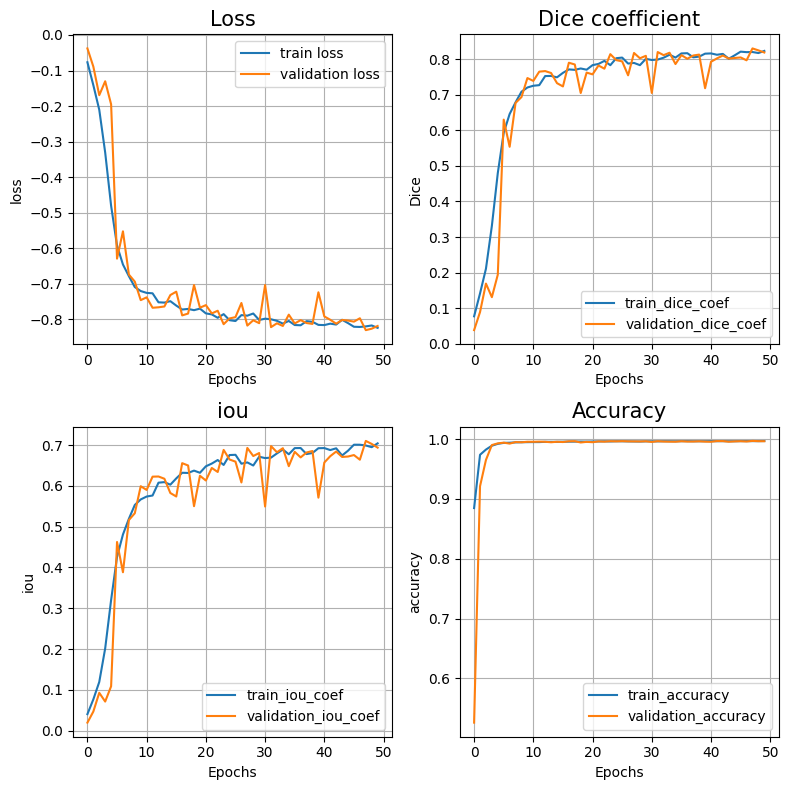

In [24]:
histori = history.history
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
train_loss = histori['loss']
val_loss = histori['val_loss']
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Loss', fontsize = 15)
plt.legend()
plt.grid()

plt.subplot(2,2,2)
train_dice = histori['dice_coef']
val_dice = histori['val_dice_coef']
plt.plot(train_dice, label= 'train_dice_coef')
plt.plot(val_dice, label= 'validation_dice_coef')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.title('Dice coefficient', fontsize = 15)
plt.legend()
plt.grid()

plt.subplot(2,2,3)
train_iou = histori['iou_coef']
val_iou = histori['val_iou_coef']
plt.plot(train_iou, label='train_iou_coef')
plt.plot(val_iou, label='validation_iou_coef')
plt.xlabel('Epochs')
plt.ylabel('iou')
plt.title('iou', fontsize = 15)
plt.legend()
plt.grid()


plt.subplot(2,2,4)
train_acc = histori['binary_accuracy']
val_acc = histori['val_binary_accuracy']
plt.plot(train_acc, label= 'train_accuracy')
plt.plot(val_acc, label= 'validation_accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Accuracy', fontsize = 15)
plt.grid()

plt.tight_layout()
plt.legend()
plt.show()

In [25]:
results = model.evaluate(test_gen, 
                         steps=len(test_data) / BATCH_SIZE)

print(f"Test loss: {results[0]:0.2f}")
print(f"Test acc: {results[1]*100:0.2f}")
print(f"Test IOU Coefficent: {results[2]:0.2f}")
print(f"Test Dice Coefficent: {results[3]:0.2f}")

Found 393 validated image filenames.
Found 393 validated image filenames.
9/9 [==============================] - 4s 413ms/step - loss: -0.8277 - binary_accuracy: 0.9965 - iou_coef: 0.7057 - dice_coef: 0.8270
Test loss: -0.83
Test acc: 99.65
Test IOU Coefficent: 0.71
Test Dice Coefficent: 0.83


2/2 [==============================] - 0s 351ms/step


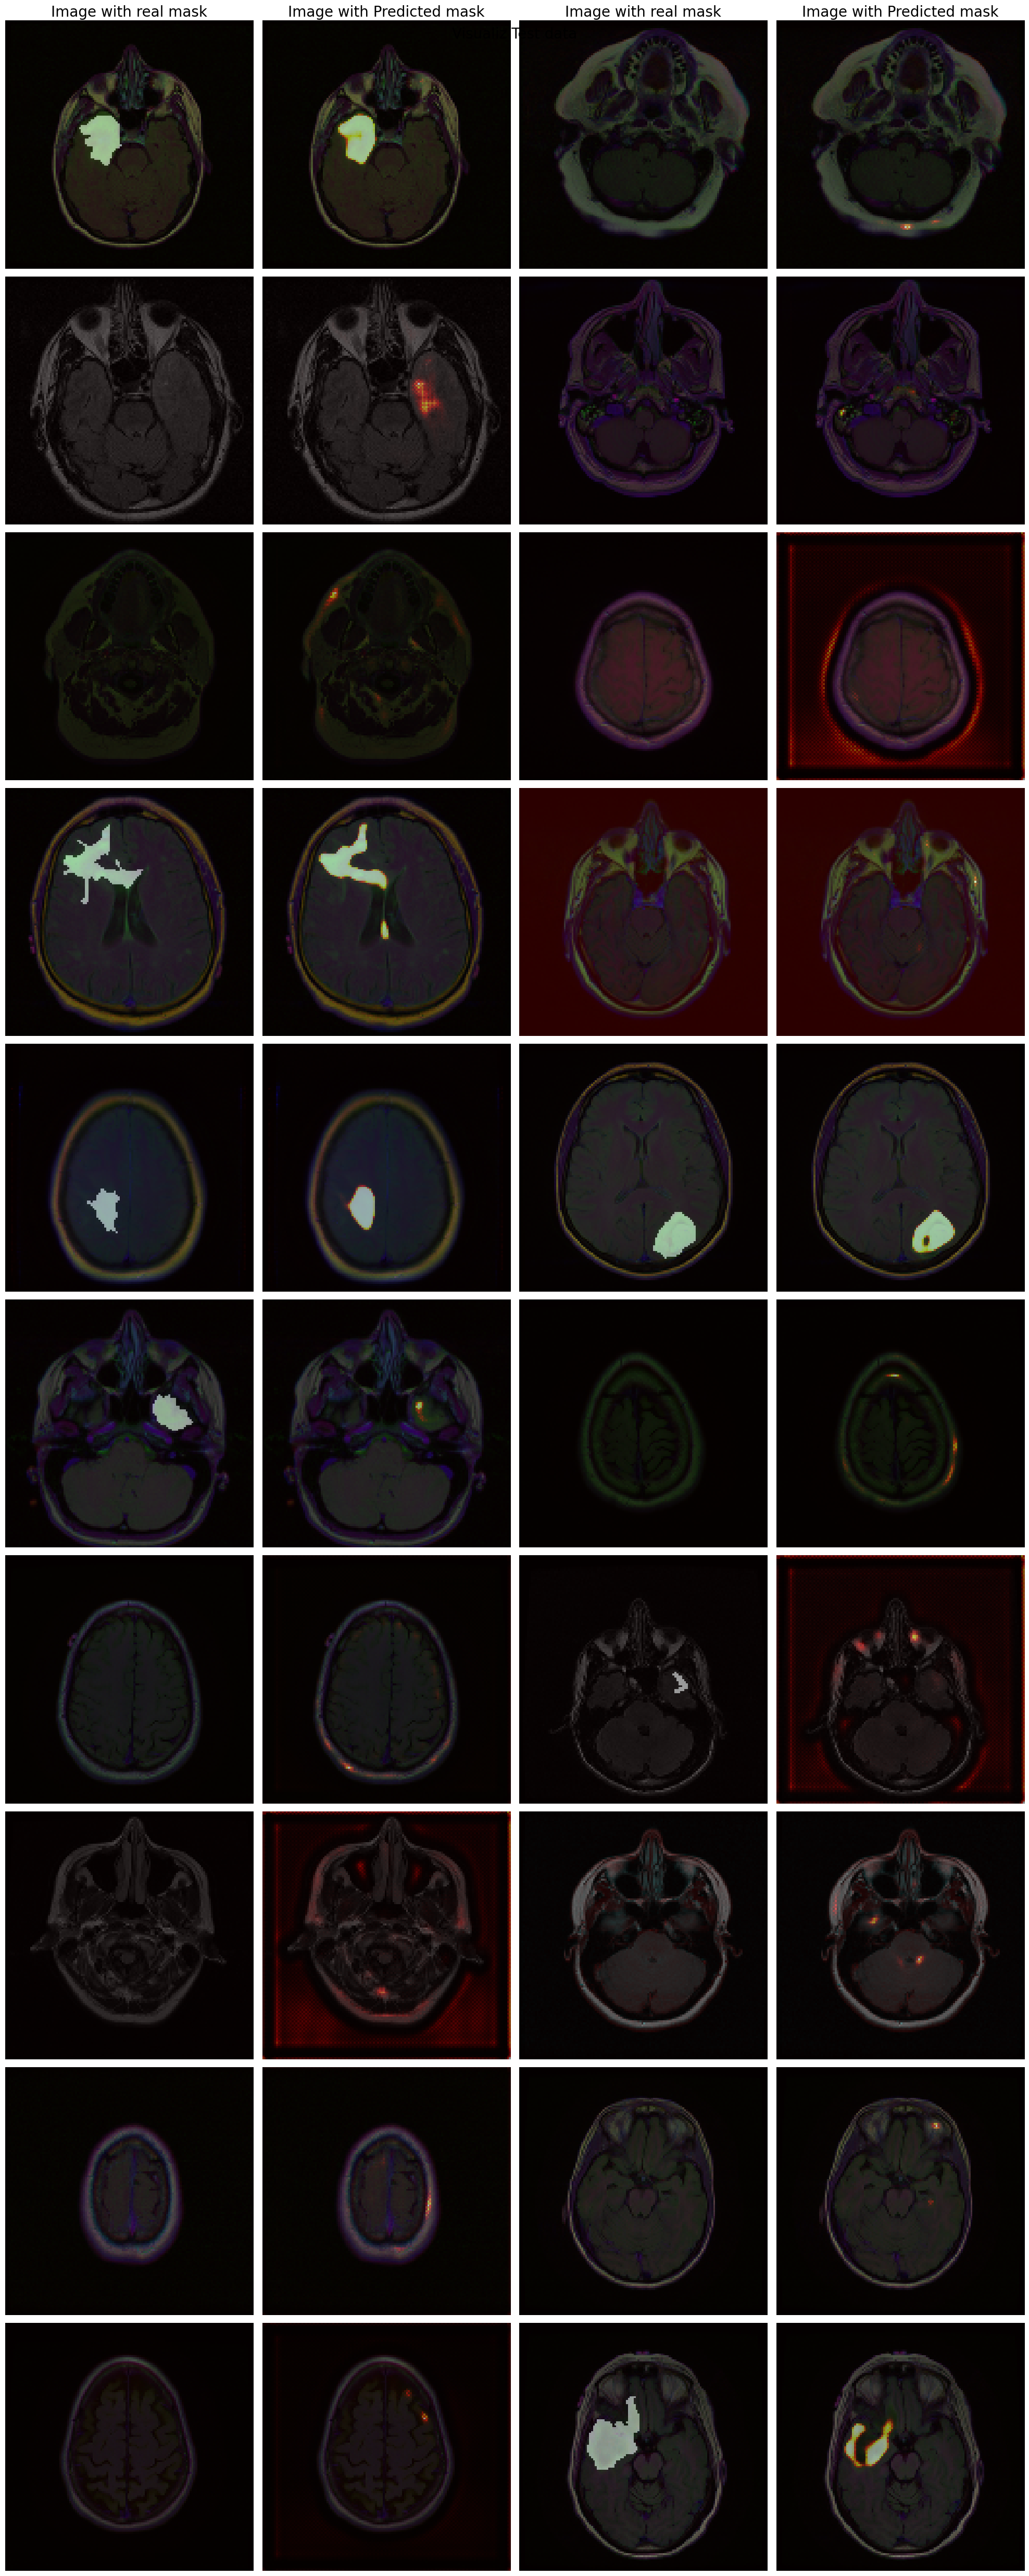

In [35]:
for img, mask in test_gen:
    break
pred = model.predict(img)

fig, ax = plt.subplots(nrows=10, ncols=4, figsize=(20,50))
plt.suptitle('Visualiz Test data', fontsize = 20)
ax = ax.ravel()

for k, i in zip(range(0, 40, 2), range(0, 40)):
    
    ax[k].imshow(img[i])
    ax[k].imshow(mask[i], alpha = 0.5, cmap = 'hot')
    ax[k].axis('off')

    
    ax[k+1].imshow(img[i])
    ax[k+1].imshow(pred[i], alpha = 0.5, cmap = 'hot')
    ax[k+1].axis('off')
    
ax[0].set_title('Image with real mask', fontsize = 20)
ax[1].set_title('Image with Predicted mask', fontsize = 20)
ax[2].set_title('Image with real mask', fontsize = 20)
ax[3].set_title('Image with Predicted mask', fontsize = 20)
plt.tight_layout()
plt.show()